**GET DATA**

Summary of this notebook: ...

Todo:

1. Self supervised representation learning using colorization as a pretext task
2. Taking in an image I , rotating it by an a set angle A--> rotated image (I_A), rotated angle A (actual label) (Done)
3. Dataloader that does this somehow (Done)
4. Some model-> ResNet50  + new full-connected layer (feature vector-> probability that image belongs to one of n classes) (Done-ish)
5. Additional training with the above model minimizing the loss wrt. actual rotated angle
f(I_A)=min[L(A_predict,A)]
6. Save this new model

7. Proof of concept:
Imagenet-> Train on Caltech validation on caltech




Definition of Done: ...

# Imports


In [1]:
# Mount Google drive
from google.colab import drive
import os
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Change to current dataset
os.chdir("/content/gdrive/Shared drives/2020_FDLUSA_Earth Science_Knowledge Discovery Framework/Code")

In [3]:
# Imports from Colab 2
import math
import numpy as np
import pickle
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import pretrained model
from tensorflow.keras.applications import MobileNet, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.


In [4]:
# Imports for Colab 6
import cv2 # Read raw image
import glob
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.preprocessing.image import Iterator


# Imports for Colorizer
from os import path
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, AveragePooling2D, Reshape, Conv2DTranspose, ZeroPadding2D
from tensorflow.keras.layers import Activation, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import random
import tensorflow as tf



In [5]:
# Check to see if GPU is being used
tensorflow.test.gpu_device_name()

'/device:GPU:0'

# Data Augmentation/Analysis

In [6]:
# Raw dataset/path/model paths
dataset = "UCMerced_LandUse"
dataPath = ("Datasets/"+ dataset+ "/Splits_2")

train_image_globs=glob.glob(dataPath+'/train/**/*.tif')
val_image_globs=glob.glob(dataPath+'/val/**/*.tif')

# Dataloader creation and test

In [7]:
dims=(256,256,3)

train_name='merced_xtrain.npy'
test_name='merced_xtest.npy'

if path.exists(train_name):
  print("Train exists")
  X_train=np.load(train_name)
else:
  X_train=np.empty((0,*dims))

  # for f in train_image_globs:
  #   image=np.expand_dims(img_to_array(load_img(f,target_size=dims))/255.,0)
  #   X_train=np.vstack((X_train,image))

  # with open(train_name, 'wb') as f:
  #   np.save(f,X_train,allow_pickle=True)
  

if path.exists(test_name):
  print("Test exists")
  X_test=np.load(test_name)
else:
  X_test=np.empty((0,*dims))

#   for f in val_image_globs:
#     image=np.expand_dims(img_to_array(load_img(f,target_size=dims))/255.,0)
#     X_test=np.vstack((X_test,image))

#   with open(test_name, 'wb') as f:
#     np.save(f,X_test,allow_pickle=True)

Train exists
Test exists


In [8]:
print(X_train.shape,X_test.shape)

(1680, 256, 256, 3) (420, 256, 256, 3)


In [9]:
train_dataGenerator = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

batch_size = 16

In [10]:
def image_a_b_gen(batch_size):
    for batch in train_dataGenerator.flow(X_train, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)


def batch_grayrgb(batch_size):
  for batch in train_dataGenerator.flow(X_train,batch_size=batch_size):
    # print(len(batch),batch[0].shape)
    gray_batch=rgb2gray(batch) #batch_size,h,w
    # print(gray_batch.shape)
    gray_batch=np.expand_dims(gray_batch,3)
    # print(gray_batch)
    gray_batch=np.repeat(gray_batch,3,axis=3) #batch_size,h,w,3
    # print(gray_batch.shape)
    X_batch=gray_batch
    Y_batch=batch
    # print(np.min(X_batch),np.max(X_batch),np.min(Y_batch),np.max(Y_batch))
    yield X_batch,Y_batch

# Model creation

In [16]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (1, 1), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))


In [11]:
model = Sequential()
# model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(InputLayer(input_shape=(256, 256, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(AveragePooling2D(pool_size=(2,2),padding='valid'))
model.add(AveragePooling2D(pool_size=(3,3),padding='valid'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
# model.add(AveragePooling2D(pool_size=(2,2),padding='valid'))
model.add(AveragePooling2D(pool_size=(3,3),padding='valid'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(AveragePooling2D(pool_size=(3,3),padding='valid'))
# model.add(AveragePooling2D(pool_size=(2,2),padding='valid'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
# model.add(AveragePooling2D(pool_size=(3,3),padding='valid'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(AveragePooling2D(pool_size=(3,3),padding='valid'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2))) # extra
# model.add(UpSampling2D((3, 3))) # extra
# model.add(ZeroPadding2D((1, 1))) # extra
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='valid'))
model.add(UpSampling2D((2, 2))) # extra
model.add(UpSampling2D((2, 2))) # extra
model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))


# Model Training

In [12]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 43, 32)        9248      
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [13]:
model.fit(batch_grayrgb(batch_size),
                    epochs=30,
                    steps_per_epoch=1680/16)


Epoch 1/30
105/105 [==============================] - 29s 273ms/step - loss: 0.0378
Epoch 2/30
105/105 [==============================] - 29s 278ms/step - loss: 0.0253
Epoch 3/30
105/105 [==============================] - 30s 281ms/step - loss: 0.0227
Epoch 4/30
105/105 [==============================] - 29s 279ms/step - loss: 0.0217
Epoch 5/30
105/105 [==============================] - 29s 280ms/step - loss: 0.0207
Epoch 6/30
105/105 [==============================] - 29s 281ms/step - loss: 0.0202
Epoch 7/30
105/105 [==============================] - 30s 282ms/step - loss: 0.0199
Epoch 8/30
105/105 [==============================] - 29s 281ms/step - loss: 0.0195
Epoch 9/30
105/105 [==============================] - 30s 283ms/step - loss: 0.0190
Epoch 10/30
105/105 [==============================] - 29s 281ms/step - loss: 0.0190
Epoch 11/30
105/105 [==============================] - 29s 281ms/step - loss: 0.0185
Epoch 12/30
105/105 [==============================] - 29s 279ms/step - lo

In [14]:
model.save('Models/Colorization_CustomCNN_epoch30_ucmerced')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Models/Colorization_CustomCNN_epoch30_ucmerced/assets


## Model Testing

In [15]:
model=load_model('Models/Colorization_CustomCNN_epoch30_ucmerced')

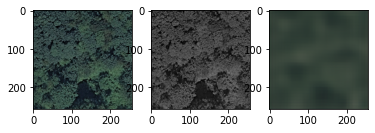

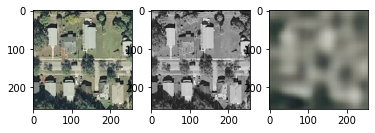

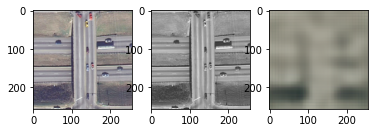

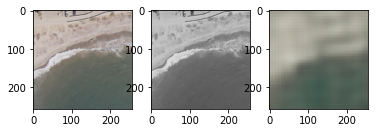

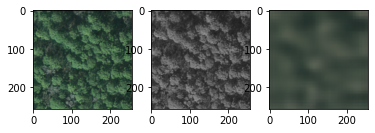

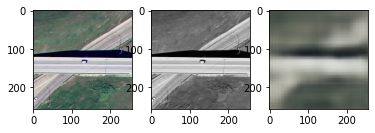

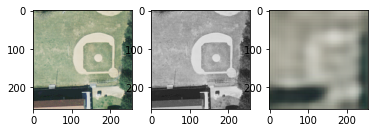

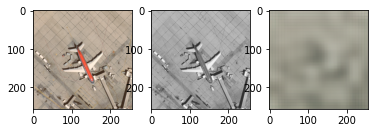

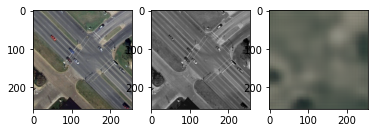

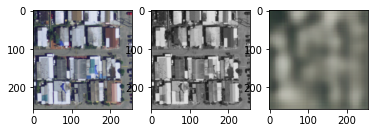

In [16]:
for i in range(10):
  index=np.random.randint(0,len(X_test))

  X_test_im=rgb2gray(np.expand_dims(X_test[index],0))
  X_test_im=np.repeat(np.expand_dims(X_test_im,3),3,axis=3)

  out_image=np.squeeze(model.predict(X_test_im))

  fig=plt.figure()
  plt.subplot(1, 3, 1)
  plt.imshow(X_test[index])
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(X_test_im))
  plt.subplot(1,3,3)
  plt.imshow(out_image)
  plt.show()

  
  

In [ ]:
X_test_m = rgb2lab(X_test)[:,:,:,0]
X_test_m = X_test_m.reshape(X_test_m.shape+(1,))
Y_test = rgb2lab(X_test)[:,:,:,1:]
Y_test = Y_test / 128
print(model.evaluate(X_test_m, Y_test, batch_size=batch_size))

27/27 [==============================] - 2s 82ms/step - loss: 0.0035
0.003506874665617943


In [ ]:
rand_index=np.random.randint(0,len(val_image_globs))

sample_image=img_to_array(load_img(val_image_globs[rand_index]))
sample_image=np.expand_dims(sample_image/255.,0)

sample_image_x=rgb2lab(sample_image)[:,:,:,0]
sample_image_x=sample_image_x.reshape(sample_image_x.shape+(1,))

# Test model
output = model.predict(sample_image_x)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = sample_image_x[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave("Models/colorization_out/img_"+str(rand_index)+".png", lab2rgb(cur))
    imsave("Models/colorization_out/raw_img_"+str(rand_index)+".png",np.squeeze(sample_image))

